In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [3]:
yelps = pd.read_csv('data/yelps.csv').sample(frac=1.)
movies = pd.read_csv('data//movies.csv').sample(frac=1.)

# Inspecting p(X) of the BOW vectorizers¶
Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data.

Of course, this is a very wide distribution, even if we just include unigrams.

Thus, we will visualize just the most popular features.

We will see how, given the most popular features of one dataset, the other dataset compares

In [4]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [5]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

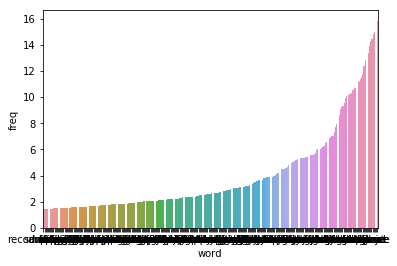

In [6]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

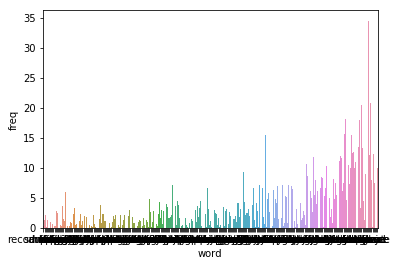

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

# Generative vs. Discriminative
Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why?

C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Rodrigo\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client 

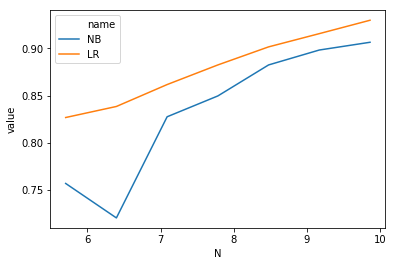

In [8]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 20, use_idf=False)
V = vectorizer.fit_transform(yelps.text)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

# Searching the Grid
Hyperparameter tuning, in its simplest form, can be done via a grid search.

We can use cross validation to estimate the out-of-sample expected risk.

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline".

In [9]:
# Perform gridsearch on a smaller sample of the data 
yelps = yelps.sample(10000)
movies = movies.sample(10000)

In [10]:
from sklearn.model_selection import train_test_split
X_train_text, X_test_text, y_train_positive, y_test_positive = train_test_split(yelps.text, 
                                                                                yelps.positive, 
                                                                                test_size=0.2, 
                                                                                random_state=1)
print(X_train_text.shape)
print(y_train_positive.shape)
print(X_test_text.shape)
print(y_test_positive.shape)

(8000,)
(8000,)
(2000,)
(2000,)


In [11]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vect' , TfidfVectorizer()),
                     ('clf'  , MultinomialNB()),])

In [12]:
parameters = {
'vect__ngram_range': [(1, 1), (1, 2)],
'vect__max_features': (None, 5000, 10000, 50000),
'clf__alpha': (1e-2, 1e-3),
}


In [13]:
from sklearn.model_selection import GridSearchCV
from time import time
gs_clf = GridSearchCV(pipeline, parameters, cv=5, iid=False, n_jobs=-1)


In [14]:
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time()
gs_clf.fit(X_train_text, y_train_positive)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % gs_clf.best_score_)
print("Best parameters set:")
best_parameters = gs_clf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__max_features': (None, 5000, 10000, 50000), 'clf__alpha': (0.01, 0.001)}
done in 136.891s

Best score: 0.925
Best parameters set:
	clf__alpha: 0.01
	vect__max_features: None
	vect__ngram_range: (1, 2)


In [15]:
# make class predictions for yelps
y_pred_class = gs_clf.predict(X_test_text)


In [16]:
from sklearn import metrics
metrics.accuracy_score(y_test_positive, y_pred_class)

0.9235

## Crosstraining
Test how well your model, when trained on one dataset, performs on the other.

To do this, make sure that you:

You perform the "fitting" of both the vectorizer and the model on one of the sets.
Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on.
Use the "predict" of your model to see how well it did on the second dataset.
How well does your model generalize from one to the other? What does this say about "sentiment"?

In [17]:
# Perform on a smaller sample of the data 
yelps = yelps.sample(10000)
movies = movies.sample(10000)

In [24]:
Vect = TfidfVectorizer(preprocessor = preprocess, ngram_range= (1, 2))
X_yelps_train = Vect.fit_transform(yelps.text)

In [25]:
nb__Multinomial = MultinomialNB(alpha= 0.01)
nb__Multinomial.fit(X_yelps_train, yelps.positive)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [26]:
X_movies_test = Vect.transform(movies.text)

In [27]:
# make class predictions for movies
y_pred_class = nb__Multinomial.predict(X_movies_test)

In [28]:
# calculate accuracy of class predictions
metrics.accuracy_score(movies.positive, y_pred_class)


0.7484

In [29]:
# calculate auc of class predictions
metrics.roc_auc_score(movies.positive, y_pred_class)

0.7492242526257242

# How well does your model generalize from one to the other?
The model, which was trained on the development set (restaurant sentiment), demonstrated  
an accuracy equal to 0.7484 on the evaluation set (movies sentiment). This accuracy was reduced from 0.9235 to 0.7484 when the model was used to predict movie data set, which means that the performance of the model decreases almost 19 percent. 

# What does this say about "sentiment"?

Sentiment is sensitive to the data we are analyzing.